## Load Grounding DINO Model

In [1]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO
!pip install -q -e .
!pip install -q roboflow
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
%cd ..
!pip install opencv-python matplotlib
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!mkdir images

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 302, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 302 (delta 34), reused 30 (delta 23), pack-reused 228
Receiving objects: 100% (302/302), 12.35 MiB | 15.94 MiB/s, done.
Resolving deltas: 100% (139/139), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
%cd GroundingDINO
from groundingdino.util.inference import Model
%cd ..
from typing import List
import os
import supervision as sv
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

/content/GroundingDINO
/content


In [ ]:
%cd images
!unzip rgb.zip
%cd ..

In [10]:
CONFIG_PATH = "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "GroundingDINO/groundingdino_swint_ogc.pth"
#IMAGE_PATH = "images/colour0001.png"
model = Model(CONFIG_PATH, WEIGHTS_PATH)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Grounding DINO Demo

In [12]:
def enhance_class_name(class_names: List[str]) -> List[str]:
    return [f"all {class_name}s" for class_name in class_names]

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [81]:
def getPrompt(CLASSES, image):
  BOX_TRESHOLD = 0.35
  TEXT_TRESHOLD = 0.25

  detections = model.predict_with_classes(
      image=image,
      classes=CLASSES,
      box_threshold=BOX_TRESHOLD,
      text_threshold=TEXT_TRESHOLD
  )
  return detections.xyxy, detections.confidence

In [20]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [85]:
def getMaskedImage(input_boxes, confidence, image, name):
  if len(input_boxes)!=0:
    if confidence[0]>0.6:
      input_box = input_boxes[0]

      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      predictor.set_image(image)
      maskList = []
      for input_box in input_boxes:
          masks, _, _ = predictor.predict(
              point_coords=None,
              point_labels=None,
              box=input_box[None, :],
              multimask_output=False,
          )
          maskList.append(masks)

      plt.figure(figsize=(4,3))
      plt.imshow(image)
      for masks in maskList:
        show_mask(masks[0], plt.gca())
      plt.axis('off')
      plt.savefig(os.path.join("newimages", name), dpi=208, bbox_inches='tight', pad_inches=0)
      plt.show()
    else:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      plt.figure(figsize=(4,3))
      plt.imshow(image)
      plt.axis('off')
      plt.savefig(os.path.join("newimages", name), dpi=208, bbox_inches='tight', pad_inches=0)
      plt.show()
  else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4,3))
    plt.imshow(image)
    plt.axis('off')
    plt.savefig(os.path.join("newimages", name), dpi=208, bbox_inches='tight', pad_inches=0)
    plt.show()

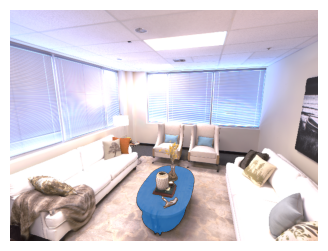

In [64]:
IMAGE_NAME = "rgb_143.png"
IMAGE_PATH = os.path.join("images", IMAGE_NAME)
CLASSES = ['table']
image = cv2.imread(IMAGE_PATH)
input_boxes, confidence = getPrompt(CLASSES, image)
getMaskedImage(input_boxes, confidence, image, IMAGE_NAME)

In [ ]:
for i in range(900):
  IMAGE_NAME = f'rgb_{i}.png'
  print(IMAGE_NAME)
  IMAGE_PATH = os.path.join("images", IMAGE_NAME)
  CLASSES = ['table']
  image = cv2.imread(IMAGE_PATH)
  input_boxes, confidence = getPrompt(CLASSES, image)
  getMaskedImage(input_boxes, confidence, image, IMAGE_NAME)

In [87]:
import shutil
shutil.make_archive('newimages', 'zip', 'newimages')

'/content/newimages.zip'